In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('default')
%matplotlib inline
import pickle

from astropy import units as u
from astropy.nddata import Cutout2D
from astropy.coordinates import SkyCoord
from astropy.coordinates import match_coordinates_sky
from astropy.wcs import WCS
from astropy.wcs.utils import pixel_to_skycoord
from astropy.wcs.utils import skycoord_to_pixel
from astropy.io import fits
from astropy.utils.data import get_pkg_data_filename

import tensorflow as tf
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)
from morpheus.classifier import Classifier
from morpheus.data import example

2022-12-15 14:16:54.788620: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-12-15 14:16:54.788675: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2022-12-15 14:16:54.967497: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2022-12-15 14:16:59.164821: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2022-12-15 14:16:59.164987: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: ca

# 1. Getting Data

## Getting HST 3D-HST Data

In [3]:
f115w_nircam_i2d = (get_pkg_data_filename('/data/jip/2nd_TASK/Morpheus_Trying/JWST_cutout_img_analysis/img/jw01345-o002_t022_nircam_clear-f115w_i2d.fits'))
f150w_nircam_i2d = (get_pkg_data_filename('/data/jip/2nd_TASK/Morpheus_Trying/JWST_cutout_img_analysis/img/jw01345-o002_t022_nircam_clear-f150w_i2d.fits'))
f200w_nircam_i2d = (get_pkg_data_filename('/data/jip/2nd_TASK/Morpheus_Trying/JWST_cutout_img_analysis/img/jw01345-o002_t022_nircam_clear-f200w_i2d.fits'))
f277w_nircam_i2d = (get_pkg_data_filename('/data/jip/2nd_TASK/Morpheus_Trying/JWST_cutout_img_analysis/img/jw01345-o002_t022_nircam_clear-f277w_i2d.fits'))
f356w_nircam_i2d = (get_pkg_data_filename('/data/jip/2nd_TASK/Morpheus_Trying/JWST_cutout_img_analysis/img/jw01345-o002_t022_nircam_clear-f356w_i2d.fits'))
f410m_nircam_i2d = (get_pkg_data_filename('/data/jip/2nd_TASK/Morpheus_Trying/JWST_cutout_img_analysis/img/jw01345-o002_t022_nircam_clear-f410m_i2d.fits'))
f444w_nircam_i2d = (get_pkg_data_filename('/data/jip/2nd_TASK/Morpheus_Trying/JWST_cutout_img_analysis/img/jw01345-o002_t022_nircam_clear-f444w_i2d.fits'))


f140w_wfc3_orig_sci = get_pkg_data_filename('/data/jip/2nd_TASK/Morpheus_Trying/VisualMorphologyTest/3D-HST/HLSP/hlsp_3dhst_hst_wfc3_aegis_f140w_v4.0_orig-sci/hlsp_3dhst_hst_wfc3_aegis_f140w_v4.0_orig-sci.fits')


h, j, v, z = f140w_wfc3_orig_sci, f140w_wfc3_orig_sci, f140w_wfc3_orig_sci, f140w_wfc3_orig_sci

# fits 특성에 따라서 ext 바꿔줘야 
hdat = fits.getdata(h, ext=0)
jdat = fits.getdata(j, ext=0)
vdat = fits.getdata(v, ext=0)
zdat = fits.getdata(z, ext=0)

h_header = fits.getheader(h, ext=0)
j_header = fits.getheader(j, ext=0)
v_header = fits.getheader(v, ext=0)
z_header = fits.getheader(z, ext=0)

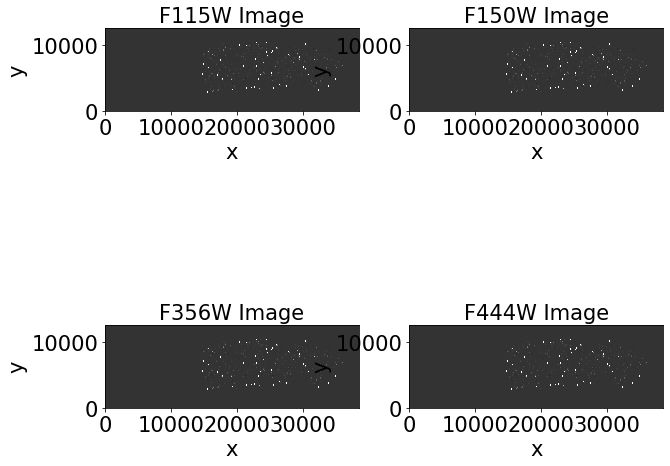

In [3]:
f, axes = plt.subplots(nrows=2, ncols=2, figsize=(10,10))
axes = np.array(axes).flatten()
for ax, arr, band in zip(axes, [hdat, jdat, vdat, zdat], ['F115W', 'F150W', 'F356W', 'F444W']):
    ax.set_title(f'{band} Image', fontsize=21)
    ax.imshow(arr, origin='lower', cmap='gray',  vmin=-0.1, vmax=0.4)
    ax.set_xlabel('x', fontsize=21)
    ax.set_ylabel('y', fontsize=21)
    ax.tick_params(axis='x', labelsize=21)
    ax.tick_params(axis='y', labelsize=21)

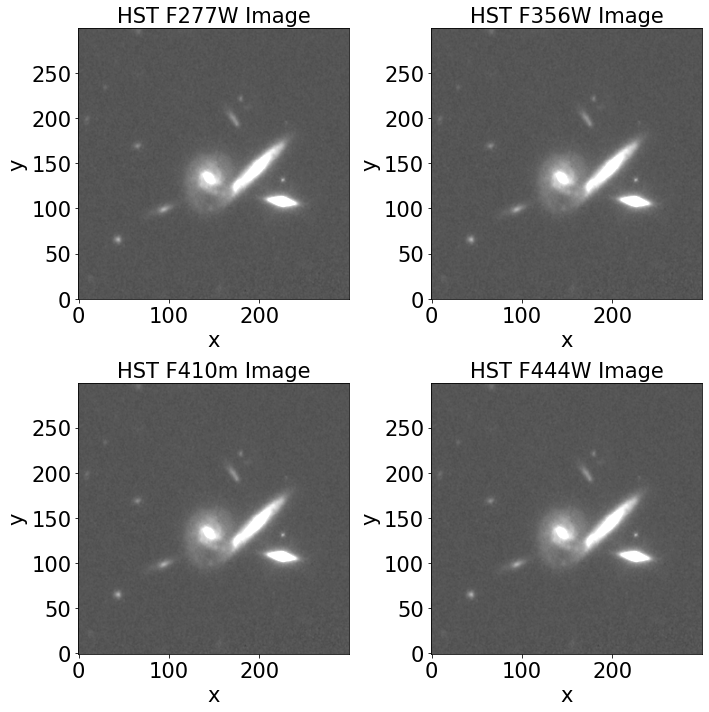

In [4]:
cutoutposition = (21650, 5450)   # (2500, 1000) size (2000, 4000)
cutoutsize = (300,300)
hcut = Cutout2D(hdat, cutoutposition, cutoutsize).data
jcut = Cutout2D(jdat, cutoutposition, cutoutsize).data
vcut = Cutout2D(vdat, cutoutposition, cutoutsize).data
zcut = Cutout2D(zdat, cutoutposition, cutoutsize).data
f, axes = plt.subplots(nrows=2, ncols=2, figsize=(10,10))
axes = np.array(axes).flatten()

for ax, arr, band in zip(axes, [hcut,jcut,vcut,zcut], ['F277W', 'F356W', 'F410m', 'F444W']):
    ax.set_title(f'HST {band} Image', fontsize=21)
    ax.imshow(arr, origin='lower', cmap='gray',  vmin=-0.3, vmax=0.6)
    ax.set_xlabel('x', fontsize=21)
    ax.set_ylabel('y', fontsize=21)
    ax.tick_params(axis='x', labelsize=21)
    ax.tick_params(axis='y', labelsize=21)

plt.tight_layout()
plt.show()

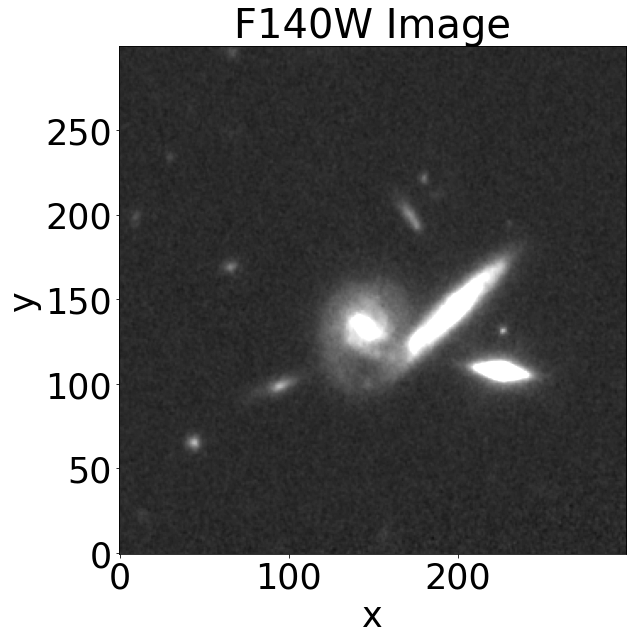

In [5]:
cutoutposition = (21650, 5450)   # (2500, 1000) size (2000, 4000)
cutoutsize = (300,300)
hcut = Cutout2D(hdat, cutoutposition, cutoutsize).data
jcut = Cutout2D(jdat, cutoutposition, cutoutsize).data
vcut = Cutout2D(vdat, cutoutposition, cutoutsize).data
zcut = Cutout2D(zdat, cutoutposition, cutoutsize).data
f, axes = plt.subplots(nrows=1, ncols=1, figsize=(9,9))
axes = np.array(axes).flatten()

for ax, arr, band in zip(axes, [hcut], ['F140W']):
    ax.set_title(f'{band} Image', fontsize=40)
    ax.imshow(arr, origin='lower', cmap='gray',  vmin=-0.1, vmax=0.5)
    ax.set_xlabel('x', fontsize=35)
    ax.set_ylabel('y', fontsize=35)
    ax.tick_params(axis='x', labelsize=35)
    ax.tick_params(axis='y', labelsize=35)

plt.tight_layout()
plt.show()

# Catalog Data

Morpheus Catalog based on 3D-HST survey

In [6]:
cat = pd.read_csv('/data/jip/2nd_TASK/Morpheus_Trying/VisualMorphologyTest/3D-HST/morpheus_EGS_value_added_catalog_rip.csv')

In [7]:
cat

,id,ra,dec,h_f160w_ab_mag,detected,area,spheroid,disk,irregular,ps_compact,background,min_bkg
0,1,215.222382,53.004185,13.914052,1,26656,0.003792,0.005274,0.000371,0.987728,0.002835,0.000000
1,2,215.096588,52.918053,18.824316,2,2470,0.155833,0.260400,0.049134,0.030338,0.504294,0.063333
2,3,215.161469,52.959461,20.359653,1,39197,0.314051,0.542293,0.026694,0.023589,0.093372,0.000000
3,4,215.305298,53.052921,24.867353,1,2859,0.016979,0.024391,0.001820,0.909915,0.046894,0.000000
4,5,215.041840,52.871273,-1.000000,0,0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...
41195,41196,214.820679,52.905525,-1.000000,0,0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
41196,41197,214.807632,52.896362,-1.000000,0,0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
41197,41198,214.820587,52.905663,-1.000000,0,0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
41198,41199,214.807007,52.897335,-1.000000,0,0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


In [8]:
tempsktp = skycoord_to_pixel(SkyCoord(cat['ra']*u.deg, cat['dec']*u.deg), wcs=WCS(h_header))
cat['real_x']=tempsktp[0]
cat['real_y']=tempsktp[1]
cat['x'] = cat['real_x']-(cutoutposition[0]-cutoutsize[1]/2) 
cat['y'] = cat['real_y']-(cutoutposition[1]-cutoutsize[0]/2) # 왜인지 모르겟으나 cutoutsize가 (y, x)임 
cat['new_id'] = cat['id']-1 #id가 dataframe 표시 순서랑 연동되는 편리한 놈 생성
cat = cat.loc[cat['x'] < cutoutsize[1]] #지금은 cutoutsize가 (y, x)로 나오고 있어 이게 맞다
cat = cat.loc[cat['x'] > 0]
cat = cat.loc[cat['y'] < cutoutsize[0]]
cat = cat.loc[cat['y'] > 0]

real_x , real_y = x, y in original h,j,v,z image

x, y = x, y in hcut,jcut,vcut,zcut image

# 3. Runnning Morpheus

In [21]:
def source_morpheus_run(x, y, cutsize, hdat, jdat, vdat, zdat, h_header):
    cp = (x, y)
    cs = (cutsize, cutsize)
    hcut2 = Cutout2D(hdat, cp, cs).data
    jcut2 = Cutout2D(jdat, cp, cs).data
    vcut2 = Cutout2D(vdat, cp, cs).data
    zcut2 = Cutout2D(zdat, cp, cs).data
    classified = Classifier.classify(h=hcut2, j=jcut2, v=vcut2, z=zcut2)
    # the mask tells the segmentation mapping algorithm to ignore
    # the areas unclassified as a result of the windowing classification
    # method used.
    mask = np.zeros_like(hcut2, np.int)
    mask[5:-5, 5:-5] = 1
    segmap = Classifier.segmap_from_classified(classified, hcut2, mask=mask)
    catalog = Classifier.catalog_from_classified(classified, hcut2, segmap)
    rgb = Classifier.colorize_classified(classified)

    wcs = WCS(h_header)

    morpheus_result = pd.DataFrame(catalog)
    morpheus_result['ra'] = pd.Series(dtype='float')
    morpheus_result['dec'] = pd.Series(dtype='float')
    morpheus_result['x'] = pd.Series(dtype='float')
    morpheus_result['y'] = pd.Series(dtype='float')
    morpheus_result['p_sph'] = pd.Series(dtype='float')
    morpheus_result['p_disk'] = pd.Series(dtype='float')
    morpheus_result['p_irr'] = pd.Series(dtype='float')
    morpheus_result['p_ps'] = pd.Series(dtype='float')

    for i in range(np.size(morpheus_result['ra'])):
        morpheus_result['x'][i] = morpheus_result['location'][i][1]
        morpheus_result['y'][i] = morpheus_result['location'][i][0]
        morpheus_result['p_sph'][i] = morpheus_result['morphology'][i][0]
        morpheus_result['p_disk'][i] = morpheus_result['morphology'][i][1]
        morpheus_result['p_irr'][i] = morpheus_result['morphology'][i][2]
        morpheus_result['p_ps'][i] = morpheus_result['morphology'][i][3]
    

    # == 지금 왜인지는 모르겟으나 a.ipynb에서 cutoutsize가 (y, x로 찍히는 걸 생각할 것)
    morpheus_result['real_x'] = morpheus_result['x']+(cp[0]-cs[1]/2)
    morpheus_result['real_y'] = morpheus_result['y']+(cp[1]-cs[0]/2)

    for i in range(np.size(morpheus_result['ra'])):
        morpheus_result['ra'][i] = pixel_to_skycoord(morpheus_result['real_x'][i], morpheus_result['real_y'][i], wcs).ra.degree
        morpheus_result['dec'][i] = pixel_to_skycoord(morpheus_result['real_x'][i], morpheus_result['real_y'][i], wcs).dec.degree
    
    return morpheus_result


In [22]:
from tqdm import tqdm 
from IPython.display import clear_output

df = pd.DataFrame(columns =['id','location','morphology','ra','dec','x','y','p_sph','p_disk','p_irr','p_ps','real_x','real_y'])

for i in tqdm(cat['new_id']):
    add = source_morpheus_run(cat['real_x'][i], cat['real_y'][i], cutsize=50, hdat=hdat, jdat=jdat, vdat=vdat, zdat=zdat, h_header=h_header)
    df = pd.concat([df, add])
    clear_output(wait=True)

100%|██████████| 20/20 [00:33<00:00,  1.69s/it]


# 4. Saving Morpheus Result / Import Morpheus Result

### Save

In [23]:
with open('df_3DHST_cutsize=50.pickle', 'wb') as f:
    pickle.dump(df, f)

### Load

In [9]:
import pickle 
with open('/data/jip/2nd_TASK/Morpheus_Trying/VisualMorphologyTest/3D-HST/df_3DHST_cutsize=50.pickle', 'rb') as f:
    df = pickle.load(f)
 

# 5. Analyze Result

## 1) Matching Catalog and Morpheus Result

In [10]:
class matchingdfcat:
    def __init__(self, dat_df, dat_catalog):  # def __init__(self, dat_df, dat_catalog, tolerance)
        tol = 0.6/3600 #RA/DEC (deg?)     # tol = tolerance / 3600
        ra_s, dec_s = dat_df['ra'], dat_df['dec']
        ra_c, dec_c = dat_catalog['ra'], dat_catalog['dec']
        src = SkyCoord(ra=ra_s*u.degree, dec=dec_s*u.degree)    # coordinates from SExtractor
        cat = SkyCoord(ra=ra_c*u.degree, dec=dec_c*u.degree)    # coordinates from catalogs
        idx, sep2d, dist3d = match_coordinates_sky(src, cat, nthneighbor=1, storekdtree='kdtree_sky')    # 매칭 함수 실행

        matched = sep2d.value < tol    # 매칭 조건 적용
        self.n_mch = np.sum(matched)    # 매칭된 개수
        self.idx_cat = idx[matched]    # cat의 매칭된 인덱스
        self.idx_src = np.where(matched)[0]    # src의 매칭된 인덱스

    def matcheddf(self, dat_df):
        return dat_df.iloc[self.idx_src]

    def matcheddf_index(self):
        return self.idx_src

    def matchedcat(self, dat_catalog):
        return dat_catalog.iloc[self.idx_cat]

    def matchedcat_index(self):
        return self.idx_cat

    def matchedsize(self):
        return self.n_mch

In [11]:
x = matchingdfcat(df, cat)

total source

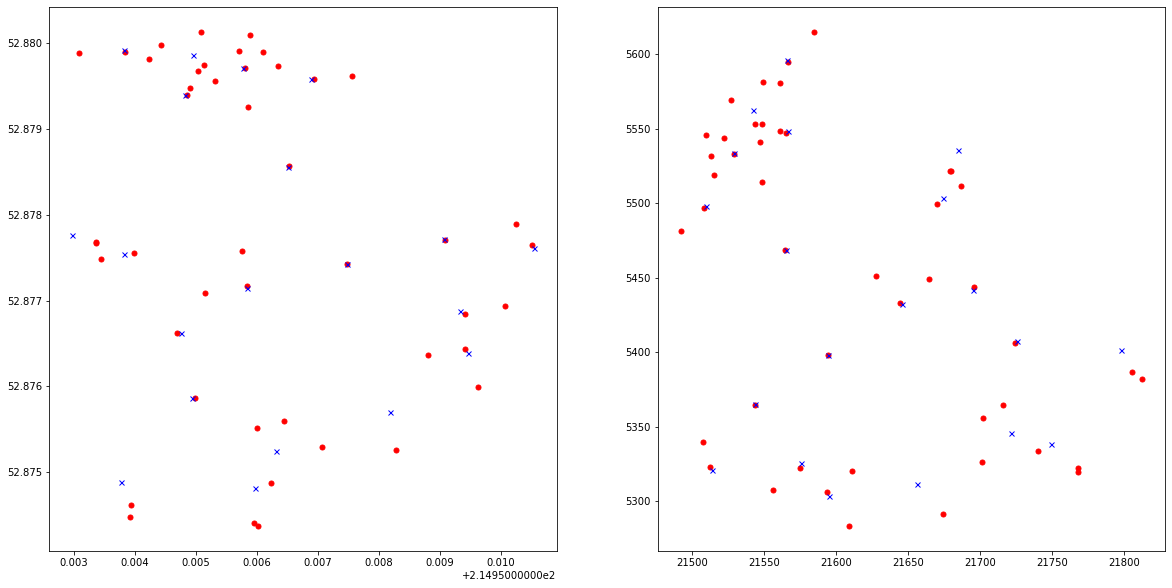

In [12]:
f, ax = plt.subplots(nrows=1, ncols=2, figsize=(20,10))
ax[0].plot(df['ra'], df['dec'], 'o', color='red', ms=5)
ax[0].plot((cat)['ra'], (cat)['dec'], 'x', color='blue', ms=5)
ax[1].plot(df['real_x'], df['real_y'], 'o', color='red', ms=5)
ax[1].plot((cat)['real_x'], (cat)['real_y'], 'x', color='blue', ms=5)

matched source

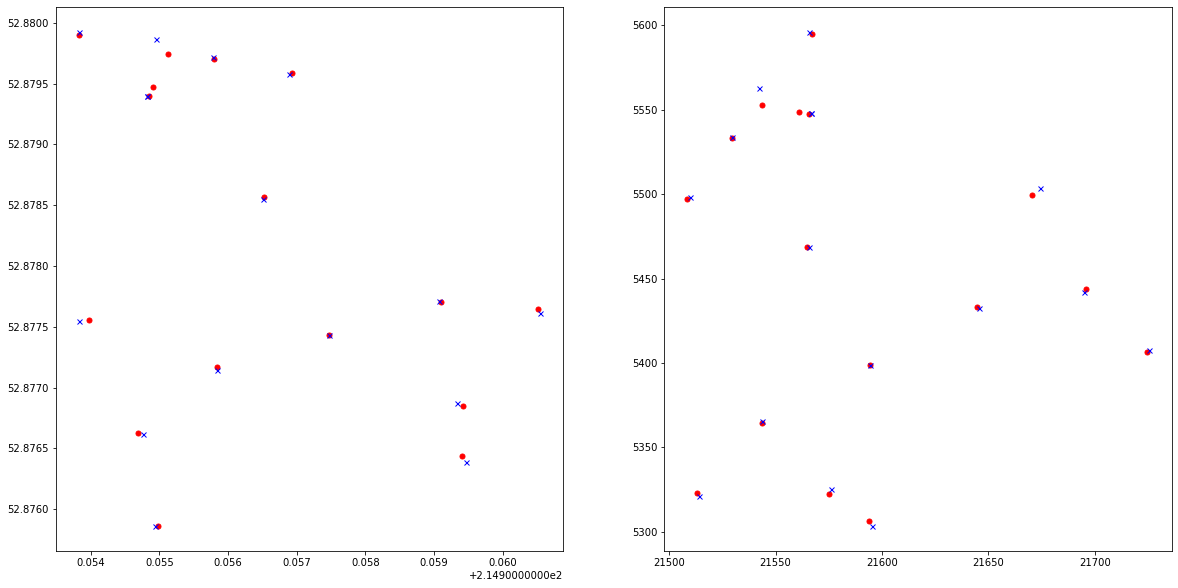

In [13]:
f, ax = plt.subplots(nrows=1, ncols=2, figsize=(20,10))
ax[0].plot(x.matcheddf(df)['ra'], x.matcheddf(df)['dec'], 'o', color='red', ms=5)
ax[0].plot(x.matchedcat(cat)['ra'], x.matchedcat(cat)['dec'], 'x', color='blue', ms=5)
ax[1].plot(x.matcheddf(df)['real_x'], x.matcheddf(df)['real_y'], 'o', color='red', ms=5)
ax[1].plot(x.matchedcat(cat)['real_x'], x.matchedcat(cat)['real_y'], 'x', color='blue', ms=5)

# No cutout Morpheus ANalysis


In [66]:
classified = Classifier.classify(h=hcut, j=jcut, v=vcut, z=zcut)
# the mask tells the segmentation mapping algorithm to ignore
# the areas unclassified as a result of the windowing classification
# method used.
mask = np.zeros_like(hcut, np.int)
mask[5:-5, 5:-5] = 1
segmap = Classifier.segmap_from_classified(classified, hcut, mask=mask)
catalog = Classifier.catalog_from_classified(classified, hcut, segmap)
rgb = Classifier.colorize_classified(classified)

wcs = WCS(h_header)

mpr = pd.DataFrame(catalog)
mpr['ra'] = pd.Series(dtype='float')
mpr['dec'] = pd.Series(dtype='float')
mpr['x'] = pd.Series(dtype='float')
mpr['y'] = pd.Series(dtype='float')
mpr['p_sph'] = pd.Series(dtype='float')
mpr['p_disk'] = pd.Series(dtype='float')
mpr['p_irr'] = pd.Series(dtype='float')
mpr['p_ps'] = pd.Series(dtype='float')

for i in range(np.size(mpr['ra'])):
    mpr['x'][i] = mpr['location'][i][1]
    mpr['y'][i] = mpr['location'][i][0]
    mpr['p_sph'][i] = mpr['morphology'][i][0]
    mpr['p_disk'][i] = mpr['morphology'][i][1]
    mpr['p_irr'][i] = mpr['morphology'][i][2]
    mpr['p_ps'][i] = mpr['morphology'][i][3]


# == 지금 왜인지는 모르겟으나 a.ipynb에서 cutoutsize가 (y, x로 찍히는 걸 생각할 것)
mpr['real_x'] = mpr['x']+(cutoutposition[0]-cutoutsize[1]/2)
mpr['real_y'] = mpr['y']+(cutoutposition[1]-cutoutsize[0]/2)

for i in range(np.size(mpr['ra'])):
    mpr['ra'][i] = pixel_to_skycoord(mpr['real_x'][i], mpr['real_y'][i], wcs).ra.degree
    mpr['dec'][i] = pixel_to_skycoord(mpr['real_x'][i], mpr['real_y'][i], wcs).dec.degree

classifying:   0%|          | 0/68 [00:00<?, ?batch/s]/home/jip/anaconda3/lib/python3.9/site-packages/morpheus/core/unet.py:143: UserWarning: `tf.layers.batch_normalization` is deprecated and will be removed in a future version. Please use `tf.keras.layers.BatchNormalization` instead. In particular, `tf.control_dependencies(tf.GraphKeys.UPDATE_OPS)` should not be used (consult the `tf.keras.layers.BatchNormalization` documentation).
  return LAYERS.batch_normalization(inputs, training=is_training, axis=axis)
/home/jip/anaconda3/lib/python3.9/site-packages/morpheus/core/unet.py:162: UserWarning: `tf.layers.conv2d` is deprecated and will be removed in a future version. Please Use `tf.keras.layers.Conv2D` instead.
  inputs = LAYERS.conv2d(
/home/jip/anaconda3/lib/python3.9/site-packages/morpheus/core/unet.py:149: UserWarning: `tf.layers.dropout` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dropout` instead.
  return LAYERS.dropout(inputs, rate=rate)
/

Building Markers...
Watershedding...


100%|██████████| 300/300 [00:00<00:00, 1919.40it/s]
/tmp/ipykernel_13178/861850784.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mpr['x'][i] = mpr['location'][i][1]
/tmp/ipykernel_13178/861850784.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mpr['y'][i] = mpr['location'][i][0]
/tmp/ipykernel_13178/861850784.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mpr['p_sph'][i] = mpr['morphology'][i][0]
/tmp/ipykernel_13178/

In [76]:
mpr

,id,location,morphology,ra,dec,x,y,p_sph,p_disk,p_irr,p_ps,real_x,real_y
0,1,"[5, 56]","[0.0, 0.0, 0.0, 1.0]",214.960124,52.876905,56.0,5.0,0.000000,0.000000,0.000000,1.000000,21556.0,5305.0
1,2,"[7, 94]","[0.0, 0.0, 0.0, 1.0]",214.959402,52.876445,94.0,7.0,0.000000,0.000000,0.000000,1.000000,21594.0,5307.0
2,3,"[7, 183]","[0.0, 0.0, 0.0, 1.0]",214.957808,52.875315,183.0,7.0,0.000000,0.000000,0.000000,1.000000,21683.0,5307.0
3,4,"[19, 288]","[-0.0, -0.0, -0.0, 1.0]",214.955677,52.874112,288.0,19.0,-0.000000,-0.000000,-0.000000,1.000000,21788.0,5319.0
4,5,"[38, 5]","[0.0, 0.0, 0.0, 1.0]",214.960343,52.877909,5.0,38.0,0.000000,0.000000,0.000000,1.000000,21505.0,5338.0
5,6,"[65, 44]","[0.985760076217375, 0.0038086447595802346, 0.0...",214.959077,52.877706,44.0,65.0,0.985760,0.003809,0.004596,0.005835,21544.0,5365.0
6,8,"[99, 95]","[7.090609790307774e-05, 0.9658284987810855, 0....",214.957449,52.877426,95.0,99.0,0.000071,0.965828,0.025844,0.008257,21595.0,5399.0
7,9,"[107, 225]","[0.0009881375936845486, 0.9940532535578995, 0....",214.954954,52.875863,225.0,107.0,0.000988,0.994053,0.000934,0.004025,21725.0,5407.0
8,10,"[169, 65]","[0.09150114707490985, 0.8751650626384682, 0.00...",214.956514,52.878563,65.0,169.0,0.091501,0.875165,0.004324,0.029010,21565.0,5469.0
9,11,"[200, 171]","[0.0033840661772474453, 0.8711199469044707, 0....",214.953965,52.877553,171.0,200.0,0.003384,0.871120,0.121700,0.003796,21671.0,5500.0


#### Image for Matched Source and Image


In [59]:
np.size(x.matcheddf(df)['ra']) / np.size(df['ra'])

0.34782608695652173

In [60]:
np.size(x.matchedcat(df)['ra']) / np.size(cat['ra'])

0.8

(-0.5, 299.5, -0.5, 299.5)

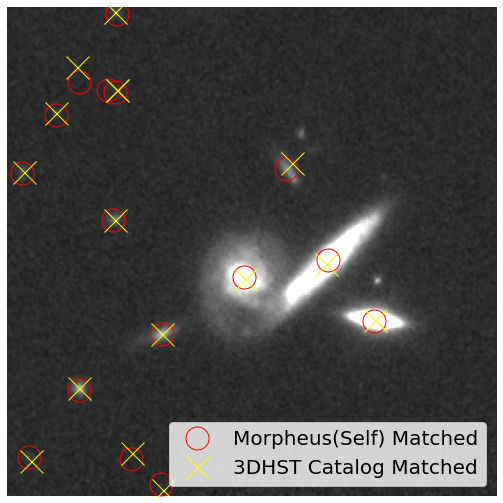

In [14]:
f, ax = plt.subplots(nrows=1, ncols=1, figsize=(22,9))
ax.imshow(hcut, origin='lower', cmap='gray',  vmin=-0.1, vmax=0.5)
ax.plot(x.matcheddf(df)['real_x']-cutoutposition[0]+cutoutsize[0]/2, x.matcheddf(df)['real_y']-cutoutposition[1]+cutoutsize[1]/2, 'o', color='red', ms=23, label='Morpheus(Self) Matched', fillstyle='none')
ax.plot(x.matchedcat(cat)['real_x']-cutoutposition[0]+cutoutsize[0]/2, x.matchedcat(cat)['real_y']-cutoutposition[1]+cutoutsize[1]/2, 'x', color='yellow', ms=23, label='3DHST Catalog Matched')
ax.legend(fontsize=20)
ax.axis('off')


(-23.45967820066926,
 328.51126642849977,
 -33.23428643102998,
 331.72640331578043)

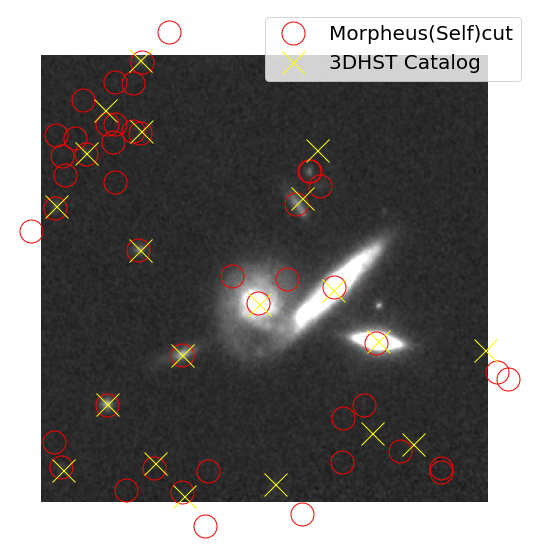

In [15]:
f, ax = plt.subplots(nrows=1, ncols=1, figsize=(10,10))
ax.imshow(hcut, origin='lower', cmap='gray',  vmin=-0.1, vmax=0.5)
ax.plot((df)['real_x']-cutoutposition[0]+cutoutsize[0]/2, (df)['real_y']-cutoutposition[1]+cutoutsize[1]/2, 'o', color='red', ms=23, label='Morpheus(Self)cut', fillstyle='none')
ax.plot((cat)['real_x']-cutoutposition[0]+cutoutsize[0]/2, (cat)['real_y']-cutoutposition[1]+cutoutsize[1]/2, 'x', color='yellow', ms=23, label='3DHST Catalog')
# ax.plot((mpr)['real_x']-cutoutposition[0]+cutoutsize[0]/2, (mpr)['real_y']-cutoutposition[1]+cutoutsize[1]/2, '+', color='blue', ms=23, label='Morpheus nocut')
ax.legend(fontsize=20, loc=1)
ax.axis('off')

## 2) Result to Table

In [52]:
matched_df = x.matcheddf(df)[['ra', 'dec', 'p_sph', 'p_disk', 'p_irr', 'p_ps', 'real_x', 'real_y']]
matched_cat = x.matchedcat(cat)[['ra', 'dec', 'spheroid', 'disk', 'irregular', 'ps_compact', 'real_x', 'real_y','h_f160w_ab_mag', 'background']]
matched_df = matched_df.reset_index(drop=True)
matched_cat = matched_cat.reset_index(drop=True)

In [53]:
df_residual = pd.DataFrame(0, index=np.arange(np.size(matched_df['ra'])), columns =['del_ra','del_dec','del_psph','del_pdisk','del_pirr','del_pcom','del_px','del_py', 'ra_mor', 'dec_mor', 'ra_cat', 'dec_cat'])

In [54]:
from tqdm import tqdm
for i in tqdm(range(np.size(matched_df['ra']))):
    df_residual['del_ra'][i]=matched_df['ra'][i]-matched_cat['ra'][i]
    df_residual['del_dec'][i]=matched_df['dec'][i]-matched_cat['dec'][i]
    df_residual['del_psph'][i]=matched_df['p_sph'][i]-matched_cat['spheroid'][i]
    df_residual['del_pdisk'][i]=matched_df['p_disk'][i]-matched_cat['disk'][i]
    df_residual['del_pirr'][i]=matched_df['p_irr'][i]-matched_cat['irregular'][i]
    df_residual['del_pcom'][i]=matched_df['p_ps'][i]-matched_cat['ps_compact'][i]
    df_residual['del_px'][i]=matched_df['real_x'][i]-matched_cat['real_x'][i]
    df_residual['del_py'][i]=matched_df['real_y'][i]-matched_cat['real_y'][i]
    df_residual['ra_mor'][i] = matched_df['ra'][i]
    df_residual['dec_mor'][i] = matched_df['dec'][i]
    df_residual['ra_cat'][i] = matched_cat['ra'][i]
    df_residual['dec_cat'][i] = matched_cat['dec'][i]

  0%|          | 0/16 [00:00<?, ?it/s]/tmp/ipykernel_13178/1054990394.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_residual['del_dec'][i]=matched_df['dec'][i]-matched_cat['dec'][i]
/tmp/ipykernel_13178/1054990394.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_residual['del_psph'][i]=matched_df['p_sph'][i]-matched_cat['spheroid'][i]
/tmp/ipykernel_13178/1054990394.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_

(array([2., 8., 0., 1., 0., 0., 0., 0., 1., 4.]),
 array([-0.1359015 , -0.02236567,  0.09117015,  0.20470598,  0.31824181,
         0.43177764,  0.54531346,  0.65884929,  0.77238512,  0.88592094,
         0.99945677]),
 <BarContainer object of 10 artists>)

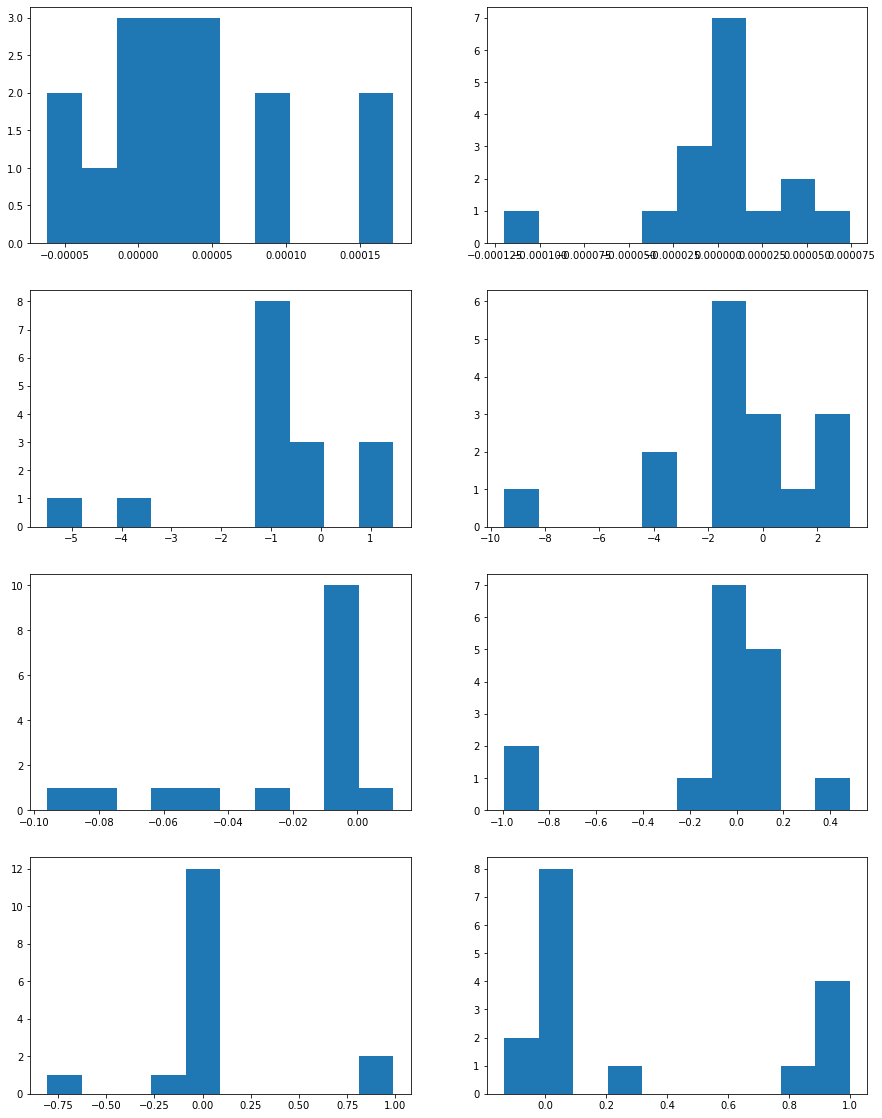

In [55]:
f, ax = plt.subplots(nrows=4, ncols=2, figsize=(15,20))
ax[0,0].hist(df_residual['del_ra'])
ax[0,1].hist(df_residual['del_dec'])
ax[1,0].hist(df_residual['del_px'])
ax[1,1].hist(df_residual['del_py'])
ax[2,0].hist(df_residual['del_psph'])
ax[2,1].hist(df_residual['del_pdisk'])
ax[3,0].hist(df_residual['del_pirr'])
ax[3,1].hist(df_residual['del_pcom'])


sph disk irr com

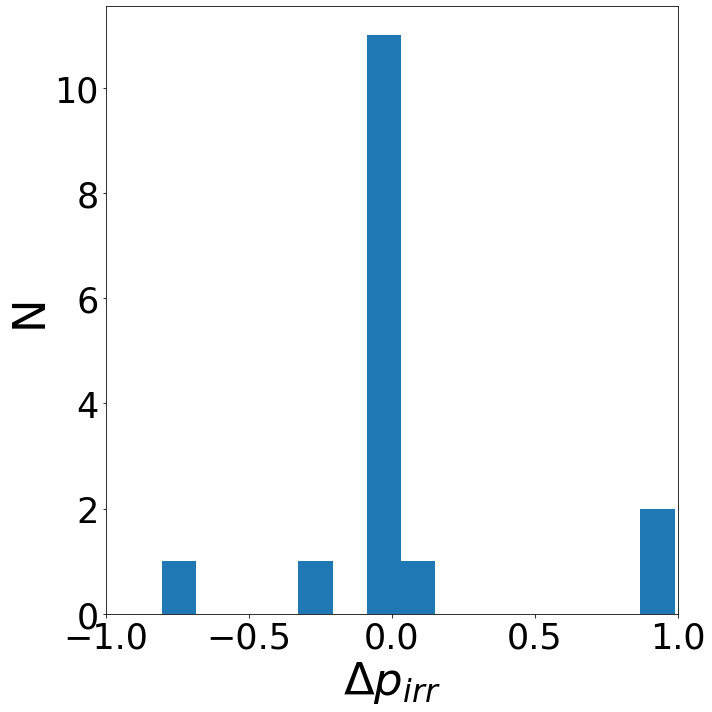

In [56]:
f, ax = plt.subplots(nrows=1, ncols=1, figsize=(10,10))
ax.hist(df_residual['del_pirr'], bins=15)
ax.tick_params(axis='both', which='major', labelsize=35)
ax.set_xlabel('$\Delta p_{irr}$', fontsize=45)
ax.set_ylabel('N', fontsize=45)
ax.set_xlim(-1,1)
plt.tight_layout()

## 3) Make Region File for Visual Morphology

Selecting disk candidates from result

In [32]:
matched_df_disk = matched_df[matched_df['p_disk']>0.5]
matched_cat_disk = matched_cat[matched_cat['disk']>0.5]
matched_cat_disk = matched_cat[matched_cat['h_f160w_ab_mag']<24.5]

#### Morpheus Result - disk

In [23]:
f = open('disk_Morpheus_3D_HST.reg', 'w')

wcs_r=WCS(h_header)

dataoption = matched_df
src2 = skycoord_to_pixel(SkyCoord(dataoption['ra']*u.deg, dataoption['dec']*u.deg), wcs=wcs_r)
src1 = np.transpose(src2)
src1 = pd.DataFrame(src1, columns=['x', 'y'])
for i in np.arange(len(src1)):
    f.write('image;circle(%.2f, %.2f, 20) \n' %(src1['x'][i], src1['y'][i]))
    # 이미지에서 source의 x, y 좌표를 중심으로 한 20 pixel 반경의 원을 display하여 보여주는 region file 쓰기

f.close()


### 디스플레이 방법: DS9 - Region - Load regions - 'test.reg' 열기

#### 3D-HST Catalog Result (Morpheus Site Release) - disk

In [24]:
f = open('disk_3D-HST_cat.reg', 'w')
dataoption = matched_cat_disk

wcs_r=WCS(h_header)

src2 = skycoord_to_pixel(SkyCoord(dataoption['ra']*u.deg, dataoption['dec']*u.deg), wcs=wcs_r)
src1 = np.transpose(src2)
src1 = pd.DataFrame(src1, columns=['x', 'y'])
for i in np.arange(len(src1)):
    f.write('image;circle(%.2f, %.2f, 20) \n' %(src1['x'][i], src1['y'][i]))
    # 이미지에서 source의 x, y 좌표를 중심으로 한 20 pixel 반경의 원을 display하여 보여주는 region file 쓰기

f.close()


### 디스플레이 방법: DS9 - Region - Load regions - 'test.reg' 열기

#### Error Analysis (뭔가 이상하게 튀어 나온 값들 다시 reg 파일로 표시 후 알아보기)

In [36]:
''' 
df_residual_error = df_residual[abs(df_residual['del_psph'])>0.5]

f, ax = plt.subplots(nrows=4, ncols=2, figsize=(15,20))
ax[2,0].hist(df_residual_error['del_psph'], alpha=0.4, color='orange', bins=5)
ax[2,1].hist(df_residual_error['del_pdisk'], alpha=0.4, color='orange', bins=5)
ax[3,0].hist(df_residual_error['del_pirr'], alpha=0.4, color='orange', bins=5)
ax[3,1].hist(df_residual_error['del_pcom'], alpha=0.4, color='orange', bins=5)


ax[0,0].hist(df_residual['del_ra'])
ax[0,1].hist(df_residual['del_dec'])
ax[1,0].hist(df_residual['del_px'])
ax[1,1].hist(df_residual['del_py'])

ax[2,0].hist(df_residual['del_psph'], alpha=0.4)
ax[2,1].hist(df_residual['del_pdisk'], alpha=0.4)
ax[3,0].hist(df_residual['del_pirr'], alpha=0.4)
ax[3,1].hist(df_residual['del_pcom'], alpha=0.4)
''' 

" \ndf_residual_error = df_residual[abs(df_residual['del_psph'])>0.5]\n\nf, ax = plt.subplots(nrows=4, ncols=2, figsize=(15,20))\nax[2,0].hist(df_residual_error['del_psph'], alpha=0.4, color='orange', bins=5)\nax[2,1].hist(df_residual_error['del_pdisk'], alpha=0.4, color='orange', bins=5)\nax[3,0].hist(df_residual_error['del_pirr'], alpha=0.4, color='orange', bins=5)\nax[3,1].hist(df_residual_error['del_pcom'], alpha=0.4, color='orange', bins=5)\n\n\nax[0,0].hist(df_residual['del_ra'])\nax[0,1].hist(df_residual['del_dec'])\nax[1,0].hist(df_residual['del_px'])\nax[1,1].hist(df_residual['del_py'])\n\nax[2,0].hist(df_residual['del_psph'], alpha=0.4)\nax[2,1].hist(df_residual['del_pdisk'], alpha=0.4)\nax[3,0].hist(df_residual['del_pirr'], alpha=0.4)\nax[3,1].hist(df_residual['del_pcom'], alpha=0.4)\n"

In [27]:
f = open('error_disk_3D-HST.reg', 'w')
dataoption = df_residual_error

wcs_r=WCS(h_header)

src2 = skycoord_to_pixel(SkyCoord(dataoption['ra_mor']*u.deg, dataoption['dec_mor']*u.deg), wcs=wcs_r)
src1 = np.transpose(src2)
src1 = pd.DataFrame(src1, columns=['x', 'y'])
for i in np.arange(len(src1)):
    f.write('image;circle(%.2f, %.2f, 20) # color=blue\n' %(src1['x'][i], src1['y'][i]))
    # 이미지에서 source의 x, y 좌표를 중심으로 한 20 pixel 반경의 원을 display하여 보여주는 region file 쓰기

f.close()


### 디스플레이 방법: DS9 - Region - Load regions - 'test.reg' 열기

Error 난 녀석들 Plot 해서 특성 파악하기

In [57]:
psph_err = df_residual[abs(df_residual['del_psph'])>0.5]
pdisk_err = df_residual[abs(df_residual['del_pdisk'])>0.5]
pirr_err = df_residual[abs(df_residual['del_pirr'])>0.5]
pcom_err = df_residual[abs(df_residual['del_pcom'])>0.5]

(array([1., 0., 0., 0., 0., 0., 1., 0., 1., 2.]),
 array([0.86513137, 0.87856391, 0.89199645, 0.90542899, 0.91886153,
        0.93229407, 0.94572661, 0.95915915, 0.97259169, 0.98602423,
        0.99945677]),
 <BarContainer object of 10 artists>)

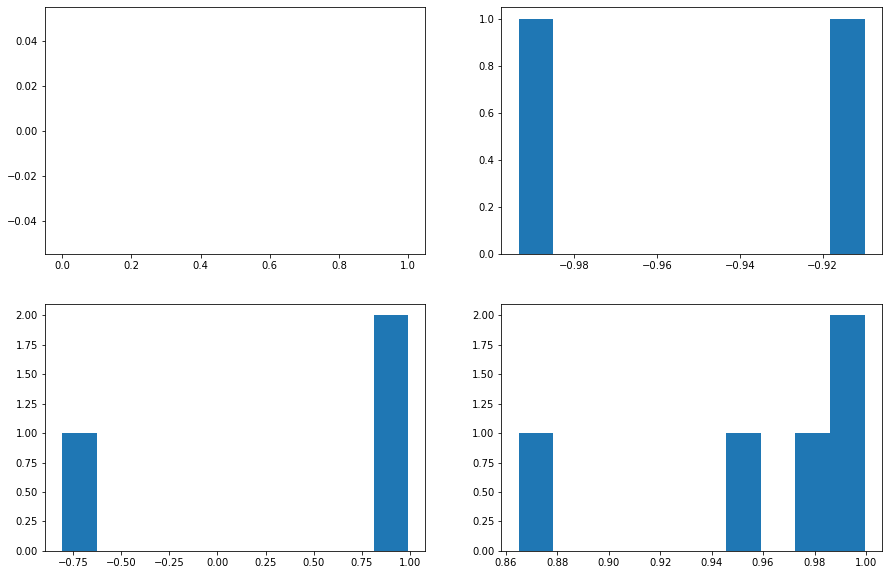

In [58]:
f, ax = plt.subplots(nrows=2, ncols=2, figsize=(15,10))
ax[0,0].hist(psph_err['del_psph'])
ax[0,1].hist(pdisk_err['del_pdisk'])
ax[1,0].hist(pirr_err['del_pirr'])
ax[1,1].hist(pcom_err['del_pcom'])



error plot

(-0.5, 299.5, -0.5, 299.5)

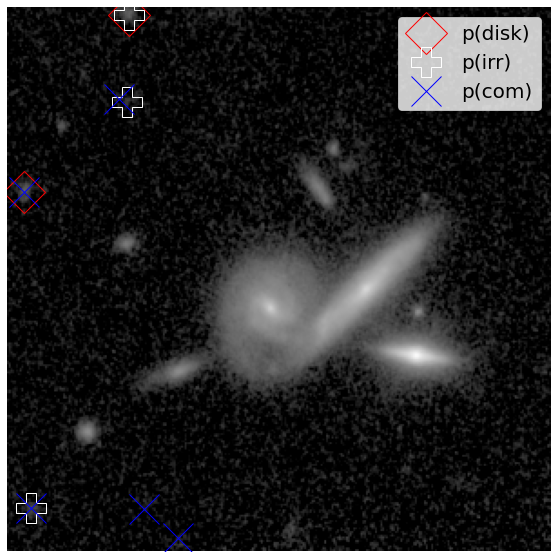

In [141]:
from astropy.visualization import make_lupton_rgb
wcs_r = WCS(h_header)
f, ax = plt.subplots(1, 1, figsize=(10,10))
image = make_lupton_rgb(hcut, jcut, vcut, stretch=0.1)
ax.imshow(image, origin='lower')

# ax.plot(skycoord_to_pixel(SkyCoord(psph_err['ra_mor']*u.deg, psph_err['dec_mor']*u.deg), wcs=wcs_r)[0]-cutoutposition[0]+cutoutsize[0]/2,skycoord_to_pixel(SkyCoord(psph_err['ra_mor']*u.deg, psph_err['dec_mor']*u.deg), wcs=wcs_r)[1]-cutoutposition[1]+cutoutsize[1]/2,'o',ms=30, color='yellow', fillstyle='none', label='p(sph)')
ax.plot(skycoord_to_pixel(SkyCoord(pdisk_err['ra_mor']*u.deg, pdisk_err['dec_mor']*u.deg), wcs=wcs_r)[0]-cutoutposition[0]+cutoutsize[0]/2,skycoord_to_pixel(SkyCoord(pdisk_err['ra_mor']*u.deg, pdisk_err['dec_mor']*u.deg), wcs=wcs_r)[1]-cutoutposition[1]+cutoutsize[1]/2,'D',ms=30, color='red', fillstyle='none', label='p(disk)')
ax.plot(skycoord_to_pixel(SkyCoord(pirr_err['ra_mor']*u.deg, pirr_err['dec_mor']*u.deg), wcs=wcs_r)[0]-cutoutposition[0]+cutoutsize[0]/2,skycoord_to_pixel(SkyCoord(pirr_err['ra_mor']*u.deg, pirr_err['dec_mor']*u.deg), wcs=wcs_r)[1]-cutoutposition[1]+cutoutsize[1]/2,'P',ms=30, color='white', fillstyle='none', label='p(irr)')
ax.plot(skycoord_to_pixel(SkyCoord(pcom_err['ra_mor']*u.deg, pcom_err['dec_mor']*u.deg), wcs=wcs_r)[0]-cutoutposition[0]+cutoutsize[0]/2,skycoord_to_pixel(SkyCoord(pcom_err['ra_mor']*u.deg, pcom_err['dec_mor']*u.deg), wcs=wcs_r)[1]-cutoutposition[1]+cutoutsize[1]/2,'x',ms=30, color='blue', fillstyle='none', label='p(com)')
ax.legend(fontsize=20)
ax.axis('off')

In [59]:
df_residual

,del_ra,del_dec,del_psph,del_pdisk,del_pirr,del_pcom,del_px,del_py,ra_mor,dec_mor,ra_cat,dec_cat
0,0.000079,-0.000024,0.000000,0.000000,0.000000,0.999457,-0.731122,-3.208404,214.959414,52.876849,214.959335,52.876873
1,-0.000046,0.000052,-0.000207,0.000000,0.000000,0.973408,-1.268878,3.208404,214.959411,52.876440,214.959457,52.876389
2,-0.000026,0.000035,-0.000063,-0.126239,-0.804763,0.946723,-1.000000,2.000000,214.960515,52.877648,214.960541,52.877613
3,0.000019,-0.000010,0.011120,-0.002304,-0.000002,-0.005881,0.000000,-1.000000,214.959095,52.877703,214.959076,52.877712
4,-0.000002,0.000001,-0.003914,0.045704,-0.019773,-0.018521,0.000000,0.000000,214.957472,52.877431,214.957474,52.877430
5,0.000016,0.000014,-0.095957,0.138159,-0.032505,-0.007175,-1.000000,0.000000,214.956529,52.878565,214.956512,52.878551
6,0.000037,0.000003,-0.000616,-0.909832,0.048624,0.865131,-1.000000,-1.000000,214.956931,52.879584,214.956894,52.879581
7,0.000019,-0.000010,-0.003993,-0.005278,-0.001430,0.068024,0.000000,-1.000000,214.955800,52.879705,214.955780,52.879715
8,0.000172,-0.000120,-0.000053,-0.002457,-0.005230,0.244582,1.458482,-9.505529,214.955128,52.879744,214.954956,52.879864
9,0.000037,0.000003,0.000000,-0.006281,0.966904,-0.005497,-1.000000,-1.000000,214.954856,52.879401,214.954819,52.879398


In [60]:
matched_df

,ra,dec,p_sph,p_disk,p_irr,p_ps,real_x,real_y
0,214.959414,52.876849,0.0,0.0,0.0,1.0,21575.246887,5322.354836
1,214.959411,52.87644,0.0,0.0,0.0,1.0,21593.978009,5306.56324
2,214.960515,52.877648,0.0,0.0,0.024612,0.975388,21512.871734,5323.108139
3,214.959095,52.877703,0.999969,0.000031,0.0,0.0,21543.724388,5364.355833
4,214.957472,52.877431,0.0,1.0,0.0,0.0,21594.228519,5398.555011
5,214.956529,52.878565,0.0,1.0,0.0,0.0,21564.550755,5468.679244
6,214.956931,52.879584,0.0,0.0,0.107583,0.892417,21508.539001,5497.217644
7,214.9558,52.879705,0.000033,0.0,-0.000016,0.999984,21529.582034,5533.123687
8,214.955128,52.879744,-0.0,-0.0,-0.0,1.0,21543.582034,5553.123687
9,214.954856,52.879401,0.0,0.0,1.0,0.0,21565.610104,5547.316568


In [65]:
matched_cat['x']=matched_cat['real_x']-(cutoutposition[0]-cutoutsize[0]/2)
matched_cat['y']=matched_cat['real_y']-(cutoutposition[1]-cutoutsize[1]/2)
matched_cat

,ra,dec,spheroid,disk,irregular,ps_compact,real_x,real_y,h_f160w_ab_mag,background,x,y
0,214.959335,52.876873,0.000000,0.000000,0.000000,0.000543,21575.978009,5325.563240,27.639761,0.999457,75.978009,25.563240
1,214.959457,52.876389,0.000207,0.000000,0.000000,0.026592,21595.246887,5303.354836,26.207407,0.973201,95.246887,3.354836
2,214.960541,52.877613,0.000063,0.126239,0.829375,0.028665,21513.871734,5321.108139,24.953150,0.015658,13.871734,21.108139
3,214.959076,52.877712,0.988849,0.002334,0.000002,0.005881,21543.724388,5365.355833,23.014262,0.002933,43.724388,65.355833
4,214.957474,52.877430,0.003914,0.954296,0.019773,0.018521,21594.228519,5398.555011,21.810323,0.003495,94.228519,98.555011
5,214.956512,52.878551,0.095957,0.861841,0.032505,0.007175,21565.550755,5468.679244,23.476182,0.002522,65.550755,168.679244
6,214.956894,52.879581,0.000616,0.909832,0.058959,0.027286,21509.539001,5498.217644,24.714591,0.003307,9.539001,198.217644
7,214.955780,52.879715,0.004026,0.005278,0.001414,0.931960,21529.582034,5534.123687,25.573455,0.057323,29.582034,234.123687
8,214.954956,52.879864,0.000053,0.002457,0.005230,0.755418,21542.123552,5562.629216,26.050368,0.236842,42.123552,262.629216
9,214.954819,52.879398,0.000000,0.006281,0.033096,0.005497,21566.610104,5548.316568,25.635615,0.955126,66.610104,248.316568


(-0.5, 299.5, -0.5, 299.5)

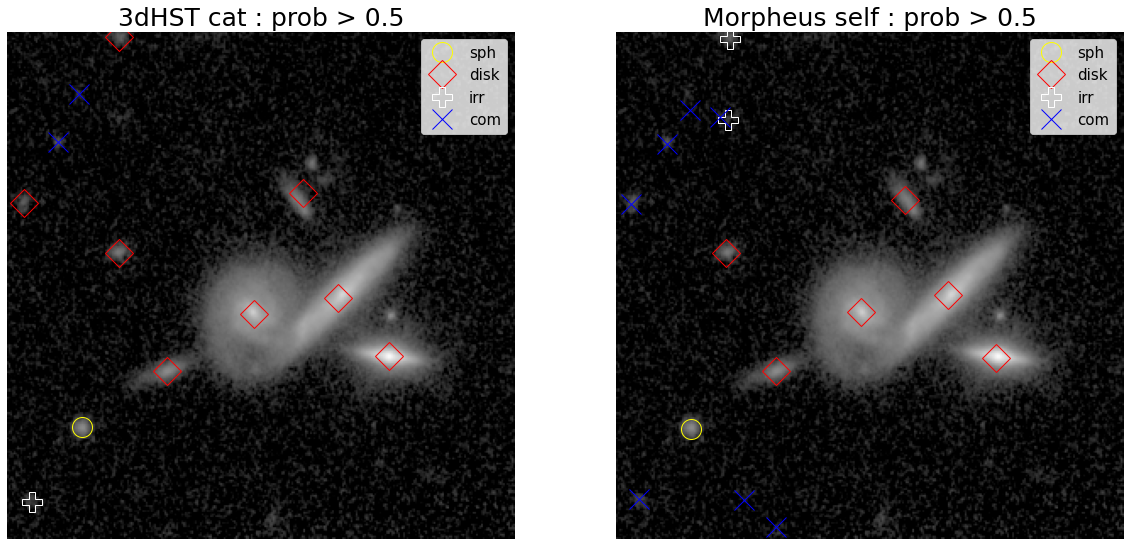

In [101]:
from astropy.visualization import make_lupton_rgb
wcs_r = WCS(h_header)
f, ax = plt.subplots(1, 2, figsize=(20,10))
image = make_lupton_rgb(hcut, jcut, vcut, stretch=0.1)
ax[0].imshow(image, origin='lower', vmin=-0.1, vmax=0.5)
ax[0].set_title('3dHST cat : prob > 0.5', fontsize=25)
ax[0].plot(skycoord_to_pixel(SkyCoord(matched_cat[(matched_cat['spheroid'])>0.5]['ra']*u.deg, matched_cat[(matched_cat['spheroid'])>0.5]['dec']*u.deg), wcs=wcs_r)[0]-cutoutposition[0]+cutoutsize[0]/2,skycoord_to_pixel(SkyCoord(matched_cat[(matched_cat['spheroid'])>0.5]['ra']*u.deg, matched_cat[(matched_cat['spheroid'])>0.5]['dec']*u.deg), wcs=wcs_r)[1]-cutoutposition[1]+cutoutsize[1]/2,'o',ms=20, color='yellow', fillstyle='none', label='sph')
ax[0].plot(skycoord_to_pixel(SkyCoord(matched_cat[(matched_cat['disk'])>0.5]['ra']*u.deg, matched_cat[(matched_cat['disk'])>0.5]['dec']*u.deg), wcs=wcs_r)[0]-cutoutposition[0]+cutoutsize[0]/2,skycoord_to_pixel(SkyCoord(matched_cat[(matched_cat['disk'])>0.5]['ra']*u.deg, matched_cat[(matched_cat['disk'])>0.5]['dec']*u.deg), wcs=wcs_r)[1]-cutoutposition[1]+cutoutsize[1]/2,'D',ms=20, color='red', fillstyle='none', label='disk')
ax[0].plot(skycoord_to_pixel(SkyCoord(matched_cat[(matched_cat['irregular'])>0.5]['ra']*u.deg, matched_cat[(matched_cat['irregular'])>0.5]['dec']*u.deg), wcs=wcs_r)[0]-cutoutposition[0]+cutoutsize[0]/2,skycoord_to_pixel(SkyCoord(matched_cat[(matched_cat['irregular'])>0.5]['ra']*u.deg, matched_cat[(matched_cat['irregular'])>0.5]['dec']*u.deg), wcs=wcs_r)[1]-cutoutposition[1]+cutoutsize[1]/2,'P',ms=20, color='white', fillstyle='none', label='irr')
ax[0].plot(skycoord_to_pixel(SkyCoord(matched_cat[(matched_cat['ps_compact'])>0.5]['ra']*u.deg, matched_cat[(matched_cat['ps_compact'])>0.5]['dec']*u.deg), wcs=wcs_r)[0]-cutoutposition[0]+cutoutsize[0]/2,skycoord_to_pixel(SkyCoord(matched_cat[(matched_cat['ps_compact'])>0.5]['ra']*u.deg, matched_cat[(matched_cat['ps_compact'])>0.5]['dec']*u.deg), wcs=wcs_r)[1]-cutoutposition[1]+cutoutsize[1]/2,'x',ms=20, color='blue', fillstyle='none', label='com')
ax[0].legend(fontsize=15)
ax[0].axis('off')


ax[1].imshow(image, origin='lower')
# ax[1].imshow(hcut, origin='lower', cmap='gray',  vmin=-0.1, vmax=0.5)

ax[1].set_title('Morpheus self : prob > 0.5', fontsize=25)
ax[1].plot(skycoord_to_pixel(SkyCoord(matched_df[(matched_df['p_sph'])>0.5]['ra']*u.deg, matched_df[(matched_df['p_sph'])>0.5]['dec']*u.deg), wcs=wcs_r)[0]-cutoutposition[0]+cutoutsize[0]/2,skycoord_to_pixel(SkyCoord(matched_df[(matched_df['p_sph'])>0.5]['ra']*u.deg, matched_df[(matched_df['p_sph'])>0.5]['dec']*u.deg), wcs=wcs_r)[1]-cutoutposition[1]+cutoutsize[1]/2,'o',ms=20, color='yellow', fillstyle='none', label='sph')
ax[1].plot(skycoord_to_pixel(SkyCoord(matched_df[(matched_df['p_disk'])>0.5]['ra']*u.deg, matched_df[(matched_df['p_disk'])>0.5]['dec']*u.deg), wcs=wcs_r)[0]-cutoutposition[0]+cutoutsize[0]/2,skycoord_to_pixel(SkyCoord(matched_df[(matched_df['p_disk'])>0.5]['ra']*u.deg, matched_df[(matched_df['p_disk'])>0.5]['dec']*u.deg), wcs=wcs_r)[1]-cutoutposition[1]+cutoutsize[1]/2,'D',ms=20, color='red', fillstyle='none', label='disk')
ax[1].plot(skycoord_to_pixel(SkyCoord(matched_df[(matched_df['p_irr'])>0.5]['ra']*u.deg, matched_df[(matched_df['p_irr'])>0.5]['dec']*u.deg), wcs=wcs_r)[0]-cutoutposition[0]+cutoutsize[0]/2,skycoord_to_pixel(SkyCoord(matched_df[(matched_df['p_irr'])>0.5]['ra']*u.deg, matched_df[(matched_df['p_irr'])>0.5]['dec']*u.deg), wcs=wcs_r)[1]-cutoutposition[1]+cutoutsize[1]/2,'P',ms=20, color='white', fillstyle='none', label='irr')
ax[1].plot(skycoord_to_pixel(SkyCoord(matched_df[(matched_df['p_ps'])>0.5]['ra']*u.deg, matched_df[(matched_df['p_ps'])>0.5]['dec']*u.deg), wcs=wcs_r)[0]-cutoutposition[0]+cutoutsize[0]/2,skycoord_to_pixel(SkyCoord(matched_df[(matched_df['p_ps'])>0.5]['ra']*u.deg, matched_df[(matched_df['p_ps'])>0.5]['dec']*u.deg), wcs=wcs_r)[1]-cutoutposition[1]+cutoutsize[1]/2,'x',ms=20, color='blue', fillstyle='none', label='com')
ax[1].legend(fontsize=15)
ax[1].axis('off')

결과 거의 비슷한데 좀 차이 나는 애들 좀만 분석하며 될 듯 ? Error 녀석 분석 --> Morpheus를 제대로 돌릴 수 있다는 사실은 명백해보인다. <br>
내일 3D HST 마무리하고 ppt 만들고 바로 JWST CEERS EGS 분석들어가면 될 듯 